# Trenowanie modelu

## Użyte biblioteki

In [3]:
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle
import gc

from PIL import Image

## Zmienne globalne

In [4]:
# Ścieżki do danych
DATA_PATH = "Data"
DATASETS = "Datasets"

TRAIN_DATASETS_PATH = os.path.join(DATASETS, "trainDatasets")
TRAIN_DATASET_PATH = os.path.join(TRAIN_DATASETS_PATH, "trainDataset")
TRAIN_TRIPLETS_PATH = os.path.join(TRAIN_DATASETS_PATH, "trainTriplets")
TRAIN_ANCHOR_DATASETS_PATH = os.path.join(TRAIN_DATASETS_PATH, "trainAnchorDataset")
TRAIN_POSITIVE_DATASETS_PATH = os.path.join(TRAIN_DATASETS_PATH, "trainPositiveDataset")
TRAIN_NEGATIVE_DATASETS_PATH = os.path.join(TRAIN_DATASETS_PATH, "trainNegativeDataset")

TEST_DATASETS_PATH = os.path.join(DATASETS, "testDatasets")
TEST_DATASET_PATH = os.path.join(TEST_DATASETS_PATH, "testDataset")
TEST_TRIPLETS_PATH = os.path.join(TEST_DATASETS_PATH, "testTriplets")
TEST_ANCHOR_DATASETS_PATH = os.path.join(TEST_DATASETS_PATH, "testAnchorDataset")
TEST_POSITIVE_DATASETS_PATH = os.path.join(TEST_DATASETS_PATH, "testPositiveDataset")
TEST_NEGATIVE_DATASETS_PATH = os.path.join(TEST_DATASETS_PATH, "testNegativeDataset")

MODEL_DIR = os.path.join("model")

## Do uczenia na Google Colab
Żeby odciążyć komputer

In [5]:
# # conection to google drive
# from google.colab import drive

# #set working directory
# drive.mount('/content/drive')
# PATH_WORKDIR = os.path.join('.', 'drive', 'My Drive', 'SNBASI')
# %cd $PATH_WORKDIR

# # Drive connection test
# !ls
# cheems = 'cheems.jpg'
# img = plt.imread(cheems)
# plt.imshow(img)

## Definicja modelu sieci neuronowej

In [6]:
# Definiowanie kształtu wejścia
input_shape = (250, 250, 3)

# Definiowanie pod-sieci (ang. base network)
def create_base_network(input_shape):
  input = Input(shape=input_shape)
  x = Conv2D(32, (5, 5), activation='relu')(input)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  return Model(inputs=input, outputs=x)

# Tworzenie pod-sieci
base_network = create_base_network(input_shape)

# Definiowanie wejść dla siamskiej sieci neuronowej
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Uzyskiwanie wektorów cech z pod-sieci
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Funkcja Lambda do obliczenia odległości Euklidesowej między wektorami cech
def euclidean_distance(vects):
  x, y = vects
  return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

# Definiowanie modelu siamskiej sieci neuronowej
model = Model([input_a, input_b], distance)

# Kompilowanie modelu
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


## Ładowanie danych w postaci batchy

In [7]:
# Generator ładowania obrazów
def load_image(image_path):
  image = load_img(image_path, target_size=(250, 250))
  image = img_to_array(image)
  return image / 255.0

def data_generator(anchor_paths, positive_paths, negative_paths, batch_size):
        num_samples = len(anchor_paths)
        while True:
            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                anchor_batch = [load_image(anchor_paths[i]) for i in range(start, end)]
                positive_batch = [load_image(positive_paths[i]) for i in range(start, end)]
                negative_batch = [load_image(negative_paths[i]) for i in range(start, end)]

                # Tworzenie etykiet
                y_positive = tf.ones((len(anchor_batch), 1))
                y_negative = tf.zeros((len(anchor_batch), 1))

                # Zwracanie batchy w odpowiednim formacie
                yield (tf.convert_to_tensor(anchor_batch), tf.convert_to_tensor(positive_batch)), y_positive
                yield (tf.convert_to_tensor(anchor_batch), tf.convert_to_tensor(negative_batch)), y_negative

# Tworzenie datasetu za pomocą tf.data.Dataset
def create_tf_dataset(anchor_paths, positive_paths, negative_paths, batch_size):
  output_signature = (
    (tf.TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32),
      tf.TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32)),
    tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
  )

  return tf.data.Dataset.from_generator(
    lambda: data_generator(anchor_paths, positive_paths, negative_paths, batch_size),
    output_signature=output_signature
  )

## Wykresy przedstawiające wyniki uczenia

In [8]:
def plot_metrics(epochs, train_metrics, val_metrics, metric_name, title, ylabel):
  plt.figure(figsize=(12, 4))

  # Wykres metryki dla zbioru treningowego
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_metrics, 'b', label=f'Training {metric_name}')
  plt.plot(epochs, val_metrics, 'r', label=f'Validation {metric_name}')
  plt.title(f'Training and validation {title} over epochs')
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.legend()

  plt.show()

## Klasa odpowiedzialna za uczenie sieci

In [9]:
class PlotTraining(Callback):
  def __init__(self):
    super(PlotTraining, self).__init__()
    self.train_losses = []
    self.train_accuracies = []
    self.val_losses = []
    self.val_accuracies = []

  def on_epoch_end(self, epoch, logs=None):
    # Przechowywanie wyników
    self.train_losses.append(logs.get('loss'))
    self.train_accuracies.append(logs.get('accuracy'))
    self.val_losses.append(logs.get('val_loss'))
    self.val_accuracies.append(logs.get('val_accuracy'))

    # Tworzenie wykresów
    epochs = range(1, len(self.train_losses) + 1)
    plot_metrics(epochs, self.train_losses, self.val_losses, 'loss', 'loss', 'Loss')
    plot_metrics(epochs, self.train_accuracies, self.val_accuracies, 'accuracy', 'accuracy', 'Accuracy')

    # Uruchomienie garbage collector po każdej epoce
    gc.collect()

## Klasa odpowiedzialna walidacje sieci

In [10]:
class EvaluateOnTestSet(Callback):
    def __init__(self, test_data, batch_size):
        self.anchor_test, self.positive_test, self.negative_test = test_data
        self.batch_size = batch_size
        self.test_losses = []
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        # Użycie generatora danych do testowania
        test_generator = data_generator(self.anchor_test, self.positive_test, self.negative_test, self.batch_size)
        steps = len(self.anchor_test) // self.batch_size

        # Ocena modelu na danych testowych
        total_loss = 0
        total_accuracy = 0
        for _ in tf.range(steps):
            (anchor_batch, positive_batch), y_positive = next(test_generator)
            (anchor_batch, negative_batch), y_negative = next(test_generator)

            # Ocena dla par anchor-positive
            loss_positive, accuracy_positive = self.model.test_on_batch([anchor_batch, positive_batch], y_positive)
            # Ocena dla par anchor-negative
            loss_negative, accuracy_negative = self.model.test_on_batch([anchor_batch, negative_batch], y_negative)

            total_loss += (loss_positive + loss_negative) / 2
            total_accuracy += (accuracy_positive + accuracy_negative) / 2
        
        avg_loss = total_loss / tf.cast(steps, dtype=tf.float32)
        avg_accuracy = total_accuracy / tf.cast(steps, dtype=tf.float32)

        # Przechowywanie wyników
        self.test_losses.append(avg_loss)
        self.test_accuracies.append(avg_accuracy)
        
        # Wyświetlanie wyników na konsoli
        print(f'\nTest Loss: {avg_loss:.4f} - Test Accuracy: {avg_accuracy:.4f}')
        
        # Tworzenie wykresów
        epochs = range(1, len(self.test_losses) + 1)
        plot_metrics(epochs, self.test_losses, self.test_losses, 'test loss', 'test loss', 'Loss')
        plot_metrics(epochs, self.test_accuracies, self.test_accuracies, 'test accuracy', 'test accuracy', 'Accuracy')

    

## Zapisywanie modelu po każdej epoce

In [11]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, file_prefix="model_", file_extension=".h5"):
        super(CustomModelCheckpoint, self).__init__()
        self.file_prefix = file_prefix
        self.file_extension = file_extension
        self.epoch_counter = 1

    def on_epoch_end(self, epoch, logs=None):
        file_name = f"{self.file_prefix}{self.epoch_counter}{self.file_extension}"
        self.model.save(os.path.join(MODEL_DIR, file_name))
        print(f"Model saved to {os.path.join(MODEL_DIR, file_name)}")
        self.epoch_counter += 1

In [12]:
# train triplets
with open(TRAIN_ANCHOR_DATASETS_PATH, 'rb') as input:
  train_anchor_data = pickle.load(input)
with open(TRAIN_POSITIVE_DATASETS_PATH, 'rb') as input:
  train_positive_data = pickle.load(input)
with open(TRAIN_NEGATIVE_DATASETS_PATH, 'rb') as input:
  train_negative_data = pickle.load(input)

# print(train_anchor_data)
# print(train_positive_data)
# print(train_negative_data)

# test triplets
with open(TEST_ANCHOR_DATASETS_PATH, 'rb') as input:
  test_anchor_data = pickle.load(input)
with open(TEST_POSITIVE_DATASETS_PATH, 'rb') as input:
  test_positive_data = pickle.load(input)
with open(TEST_NEGATIVE_DATASETS_PATH, 'rb') as input:
  test_negative_data = pickle.load(input)

# print(test_anchor_data)
# print(test_positive_data)
# print(test_negative_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5082 - loss: 7.4008 

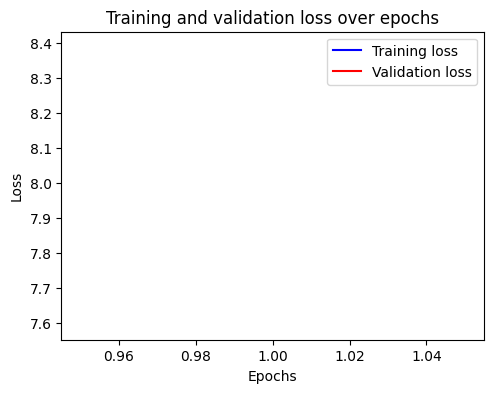

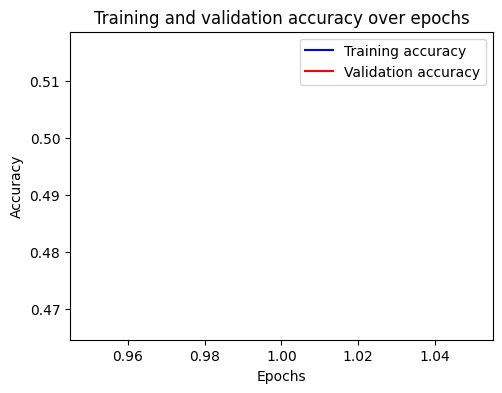

In [13]:
# Tworzenie generatora danych
batch_size = 64
train_dataset = create_tf_dataset(train_anchor_data, train_positive_data, train_negative_data, batch_size)

# Obliczanie liczby kroków na epokę
steps_per_epoch = len(train_anchor_data) // batch_size

# Definiowanie instancji callbacku PlotTraining
plot_training = PlotTraining()

# Tworzenie instancji callback'a EvaluateOnTestSet
evaluate_on_test_set = EvaluateOnTestSet(test_data=(test_anchor_data, test_positive_data, test_negative_data), batch_size=batch_size)

# Tworzenie instancji callbacka
custom_checkpoint = CustomModelCheckpoint()

# Trenowanie modelu
# history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10)

# Trenowanie modelu z callbackami
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=[plot_training, evaluate_on_test_set, custom_checkpoint])

# zapisz model do pliku
# model.save(os.path.join(MODEL_DIR, "siamese_network_model.h5"));

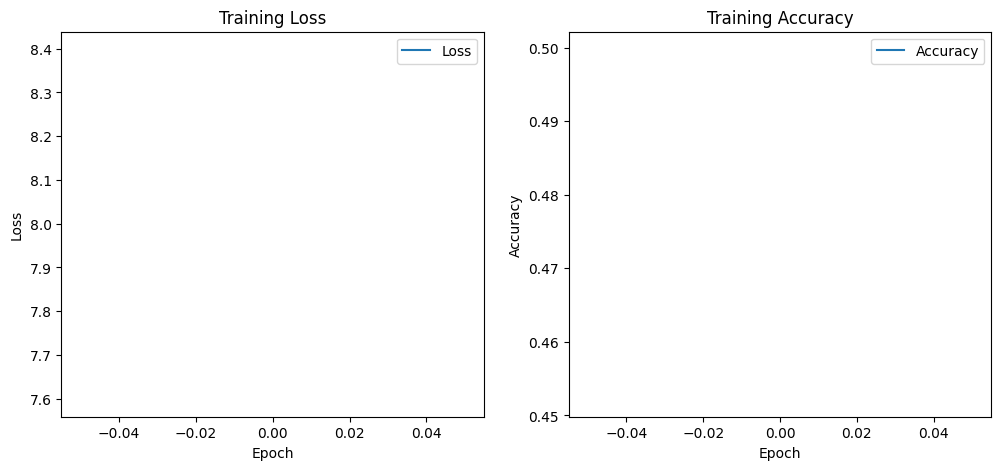

In [ ]:
def plot_training_history(history):
    # Rysowanie wykresu straty
    plt.figure(figsize=(12, 5))

    # Wykres straty

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Wykres trafności
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Wywołanie funkcji do rysowania wykresów
plot_training_history(history)

In [ ]:
# Ładowanie modelu z pliku
# loaded_model = tf.keras.models.load_model('model_1.h5')

# Załaduj wagi modelu
model1 = Model([input_a, input_b], distance)

# Kompilowanie modelu
model1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model1.load_weights('model/model_1.h5')

# Alternatywnie, możesz załadować tylko wagi do nowego modelu:
# Tworzysz nowy model o tej samej architekturze
# loaded_model = create_model()
# loaded_model.load_weights('siamese_network_weights.h5')

# Użyj załadowanego modelu do przewidywań lub dalszego treningu
# Przykład przewidywania:
# predictions = loaded_model.predict([anchor_test, positive_test])

elo
